# <center>Final project "Analyzing phone market"</center>

## <center>Part 1: Getting, parsing and saving the data</center>

### 1. Імпортуємо бібліотеку requests (для звернення до веб-ресурсів), beautifulSoup (для конверсії відповіді response в об'єкт html-soup), sqlite3 - (для роботи з sqlite), pandas - (для роботи з датафреймами).

In [1]:
import requests                   # бібліотека для здійснення запитів
from bs4 import BeautifulSoup     # для парсингу html
import sqlite3                    # для роботи з БД, зокрема SQlite
import pandas as pd               # для роботи з датафреймами

### 2. У якості використовуваного веб-ресурсу приймемо [сторінку з гаджетами](https://can.ua/smartphones/c1538/). Звернемося до неї та отримаємо першу сторінку:

In [7]:
url_base = "https://can.ua/smartphones/c1538/" # початкова сторінка з данними
url_page="page=" # додаток до адреси для отримання сторінки

data = requests.get(url_base + url_page + str(1)) # отримання першої сторінки

### 3. Якщо сайт дозволив отримати дані (статус код = 200), то конвертуємо дані в об'єкт BeautifulSoup для подальшої роботи і створюємо базу даних для запису отриманих даних. В іншому випадку - сповіщаємо, який статус код прийшов користувачу і завершуємо роботу програми:

In [8]:
if data.status_code == 200:
    print("Data was successfully retrieved (200)")
    
    soup = BeautifulSoup(data.text, "html.parser") # парсимо текст відповіді в об'єкт ГарногоСупа
    
    db = sqlite3.connect("cellphones.db") # створили базу даних з назвою cellphones, або підключились до існуючої (якщо вона була)
    cur = db.cursor() # отримали курсор (мідлуеар) для подальшого оперування запитами
    
    # створюємо таблицю cellphones, у якій будемо зберігати:
        # id_cellphone - унікальний артикул товару з сайту
        # title - повна назва товару
        # photo_ref - посилання на головну фотографію товару
        # price - ціна товару
        # model - модель товару
    cur.execute('''CREATE TABLE IF NOT EXISTS cellphones(
        id_cellphone INT NOT NULL PRIMARY KEY, 
        title VARCHAR(100) NOT NULL,
        photo_ref VARCHAR(255) NULL, 
        price INT NOT NULL, 
        model VARCHAR(100) NOT NULL ) ''')
         
    # створюємо таблицю characteristics, у якій будемо зберігати:
        # id_phone - унікальний ідентифікатор у таблиці, автоінкрементний
        # model_id - унікальний артикул товару з сайту, прив'язаний до таблиці cellphones
        # display - діагональ дісплею
        # display_size - розмір дісплею
        # cores_num - кількість ядер
        # ram_gb - оперативна пам'ять
        # IMC_gb - внутрішня пам'ять
        # camera_mp - мегапікселі камери
        # os - операційна система
    cur.execute('''CREATE TABLE IF NOT EXISTS characteristics(
        model_id INT NOT NULL PRIMARY KEY, 
        display FLOAT NOT NULL,
        display_size VARCHAR(45) NOT NULL,
        cores_num INT NOT NULL,
        ram_gb INT NOT NULL, 
        IMC_gb INT NOT NULL,
        camera_mp INT NOT NULL,
        os VARCHAR(45) NOT NULL, 
        FOREIGN KEY(model_id) REFERENCES cellphones(id_cellphone))''')
        
    db.commit() # commit the transaction (saves changes in DB)
    cur.close() # позначаємо програмі кінець поточної операції з курсором, зачиняючи його
    
else:
    print("Unable to retrieve the data. Response code = ", data.status_code)

Data was successfully retrieved (200)


### <center>Схема спроектованої бази даних з Power BI</center>

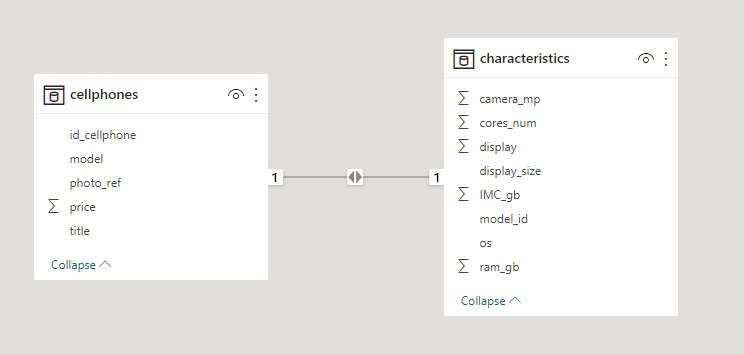

### 4. Якщо статус код = 200, то отримуємо кількість сторінок як максимальний елемент списку сторінок на сайті. Розпочинаємо цикл по всім сторінкам для отримання даних. Створюємо БД та таблиці, записуємо в них отримані дані. Для подробиць, будь ласка, зверніться до коментарів у програмі:

In [36]:
if data.status_code == 200: # якщо сайт не проти
    print("Data was successfully retrieved (200)")
    
    # отримуємо кількість сторінок розділу
    pages_qty = int(soup.select_one("ul[name='paginator'] li:nth-last-child(2)").get_text()) 
    # отримуємо label'и зі списку моделей сайту
    model_labels = soup.select("#desktop_sort-producer > ul > li > label")
    models = [] # список моделей з сайту (для подальшого їх аналізу у назві товару)

    for model in model_labels: # для кожної моделі зі списку
        models.append(model.get_text().split("(")[0].strip()) # парсимо лише назву моделі у масив з моделями
    
    for i in range(1, pages_qty+1): # цикл по всім сторінкам
        print("Fulfilling page #", i, "... of", pages_qty) # виводимо номер поточної сторінки, щоб розуміти прогрес виконання програми
        if i != 1: # для першої сторінки нічого не робимо, тому що у якості тестового запиту вона вже була отримана
            data = requests.get(url_base + url_page + str(i)) # а для інших сторінок посилаємо запит на новую сторінку
        
        soup = BeautifulSoup(data.text, "html.parser") # парсимо текст відповіді в об'єкт ГарногоСупа
        
        page_products = soup.select(".catalog-tile li") # отримуємо всі товари з поточної (і) сторінки
        
        for product in page_products: # цикл по всіх продуктах поточної сторінки (за замовчуванням сайту 40 шт. на сторінці)
            id = product.select_one("div.info__code").get_text().strip()[5:] # унікальний артикул товару з сайту
            title = product.select_one("a.info__name").get_text()  # повна назва товару
            price = 0 # за замовчуванням - ціна 0
            price_element = product.select_one("p.item__price") # елемент, з якого читаємо ціну
            
            if price_element: # якщо такий елемент знайдено
                price = (price_element.get_text()[:-4]).replace(" ", '')  # ціна товару зберігається (відповідно, товар є в наявності)
            
            photo_ref = product.select_one("img")['src']  # посилання на фотографію товару
            model = "" # модель товару, що обмежена значеннями
            
            for curr_model in models: # цикл по всім моделям
                if curr_model in title: # перевіряємо кожну і зупиняємося, коли знайшли
                    model = curr_model # перед зупинкою зберігаємо значення, що знайшли
                    break # сама зупинка
            
            # секція "додаткові параметри"
            display = product.select_one(".item__hidden > p >b:nth-child(1)").get_text()[:-2]  # діагональ дісплею
            display_size = product.select_one(".item__hidden > p >b:nth-child(3)").get_text() # розмір дісплею
            cores_num = product.select_one(".item__hidden > p >b:nth-child(5)").get_text() # кількість ядер
            ram = product.select_one(".item__hidden > p >b:nth-child(7)").get_text()[:-3] # оперативна пам'ять
            imc = product.select_one(".item__hidden > p >b:nth-child(9)").get_text()[:-3] # внутрішня пам'ять
            camera = product.select_one(".item__hidden > p >b:nth-child(11)").get_text()[:-3] # мегапікселі камери
            os = product.select_one(".item__hidden > p >b:nth-child(13)").get_text() # операційна система
            
            cur = db.cursor() # оголошуємо курсор знову, позначаючи початок роботи із запитами
            # записали дані у першу таблицю
            try: # спробувати записати дані у БД
                cur.execute('INSERT INTO cellphones VALUES(?, ?, ?, ?, ?)', (id,title, photo_ref, price,model))
                # записали дані у другу таблицю
                cur.execute('INSERT INTO characteristics VALUES(?, ?, ?, ?, ?, ?, ?, ?)', (id, display,display_size,cores_num, ram, imc, camera, os))
            except sqlite3.IntegrityError as e: # якщо була помилка порушення цілісності
                if 'UNIQUE constraint' in e.args[0]: # якщо дублюється унікальний запис
                    print("Немає можливості додати запис(и), тому що вони порушують унікальність коду БД. Спробуйте спочатку видалити ці записи або просто видаліть БД та запустіть програму")
                else: # інша помилка
                    print("Error: ", e)

                break # при помилці не продовжувати парсинг сторінок і запис у БД
            else: # якщо все пройшло без помилок
                db.commit() # зберігаємо зміни
            finally: # виконувати у будь-якому разі
                cur.close() # позначаємо кінець поточних транзакцій
                
    db.close() # завершуємо роботу з базою даних        
    print("Done") # сповіщаємо користувача, що програма завершила роботу
else:
    print("Unable to retrieve data. Response code = ", data.status_code) # у разі помилки із самого початку
    


Data was successfully retrieved (200)
Fulfilling page # 1 ... of 25
Fulfilling page # 2 ... of 25
Fulfilling page # 3 ... of 25
Fulfilling page # 4 ... of 25
Fulfilling page # 5 ... of 25
Fulfilling page # 6 ... of 25
Fulfilling page # 7 ... of 25
Fulfilling page # 8 ... of 25
Fulfilling page # 9 ... of 25
Fulfilling page # 10 ... of 25
Fulfilling page # 11 ... of 25
Fulfilling page # 12 ... of 25
Fulfilling page # 13 ... of 25
Fulfilling page # 14 ... of 25
Fulfilling page # 15 ... of 25
Fulfilling page # 16 ... of 25
Fulfilling page # 17 ... of 25
Fulfilling page # 18 ... of 25
Fulfilling page # 19 ... of 25
Fulfilling page # 20 ... of 25
Fulfilling page # 21 ... of 25
Fulfilling page # 22 ... of 25
Fulfilling page # 23 ... of 25
Fulfilling page # 24 ... of 25
Fulfilling page # 25 ... of 25
Done


### 5. Отримуємо дані із БД:

In [96]:
db = sqlite3.connect("cellphones.db") # підключаємося до БД cellphones.db
cur = db.cursor() # оголошуємо новий курсор

# за допомогою об'єднання таблиць отримуємо всі дані з БД
cur.execute('''SELECT id_cellphone, title, photo_ref, price, model, display, display_size, cores_num, ram_gb, IMC_gb, camera_mp, os 
                FROM cellphones 
                LEFT JOIN characteristics ON cellphones.id_cellphone = characteristics.model_id''')
df = pd.DataFrame(cur.fetchall(), columns=["Артикул", "Назва", "Фото", "Ціна", "Модель", "Дисплей", "Розмір дисплею", "Кількість ядер", "Оперативна пам'ять", "Внутрішня пам'ять", "Камера", "Операційка"])

cur.close() # кінець поточних транзакцій
db.close() # завершуємо роботу з зазою даних

df.head()

,Артикул,Назва,Фото,Ціна,Модель,Дисплей,Розмір дисплею,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка
0,345194,Смартфон NOKIA G10 3/32GB Night,https://i.can.ua/images/244x190/goods/8341/834...,3999,NOKIA,6.50,1600x720 (HD+),8,3,32,13.0,Android
1,346475,Смартфон REDMI Note 10 Pro 6/128GB Onyx Gray,https://i.can.ua/images/244x190/goods/8393/839...,9999,REDMI,6.67,2400x1080 (Full HD+),8,6,128,108.0,Android
2,349393,Смартфон ONEPLUS Nord N100 4/64GB Midnight Frost,https://i.can.ua/images/244x190/goods/8571/857...,6999,ONEPLUS,6.52,1600x720 (HD+),8,4,64,13.0,Android
3,364817,Смартфон VIVO Y31 4/64GB Ocean Blue,https://i.can.ua/images/244x190/goods/9284/928...,7173,VIVO,6.58,2400x1080 (Full HD+),8,4,64,48.0,Android
4,365575,Смартфон SAMSUNG Galaxy M52 6/128GB Light Blue...,https://i.can.ua/images/244x190/goods/9327/932...,11790,SAMSUNG,6.70,2400x1080 (Full HD+),8,6,128,64.0,Android


## Part 2: Visualization

In [76]:
import matplotlib.pyplot as plt    # import the library for visualizing
import seaborn as sns              # for plots styling

In [77]:
display(df.describe()) # describe the data
df.isnull().values.any() # check for nulls (if any)

,Артикул,Ціна,Дисплей,Кількість ядер,Внутрішня пам'ять,Камера
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,378000.014257,9626.064155,6.398656,7.303462,119.845214,39.376171
std,29910.138488,15827.538988,0.431751,1.346861,102.782831,32.749700
min,95294.000000,0.000000,4.700000,4.000000,1.000000,4.000000
25%,374083.250000,0.000000,6.367500,8.000000,64.000000,13.000000
50%,387305.500000,4684.500000,6.500000,8.000000,128.000000,48.000000
75%,394836.750000,8495.500000,6.600000,8.000000,128.000000,50.000000
max,406100.000000,79052.000000,8.300000,8.000000,512.000000,200.000000


False

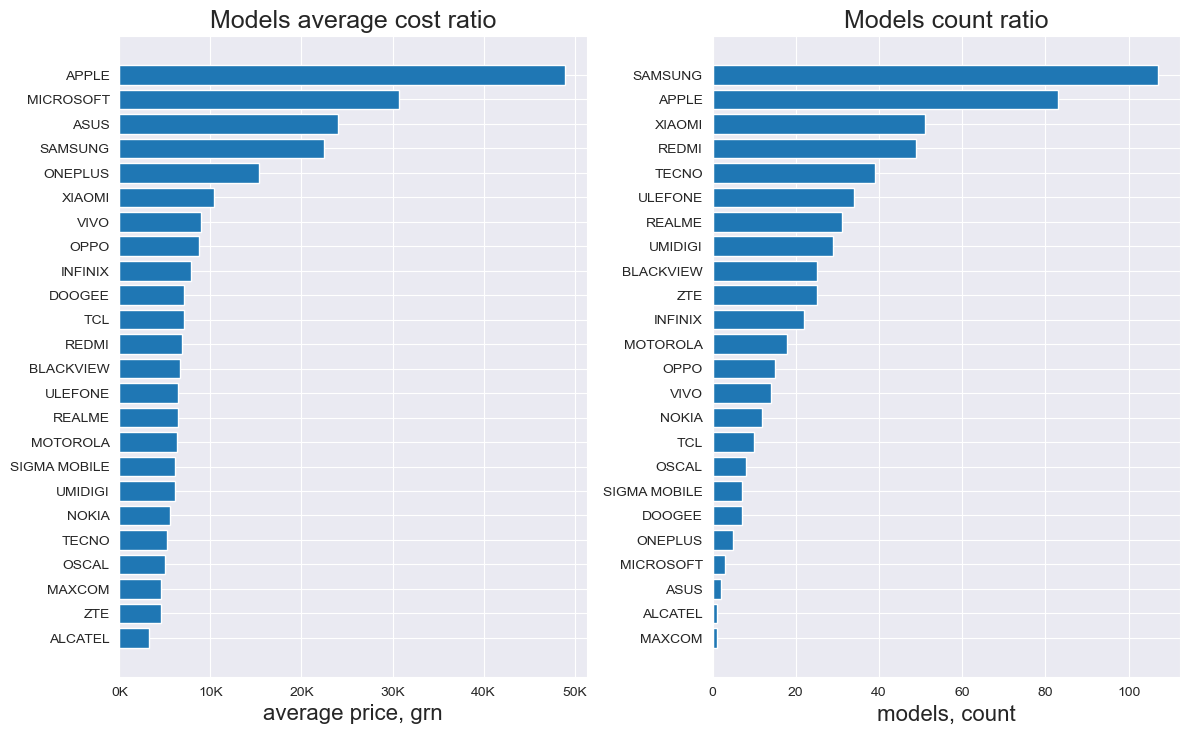

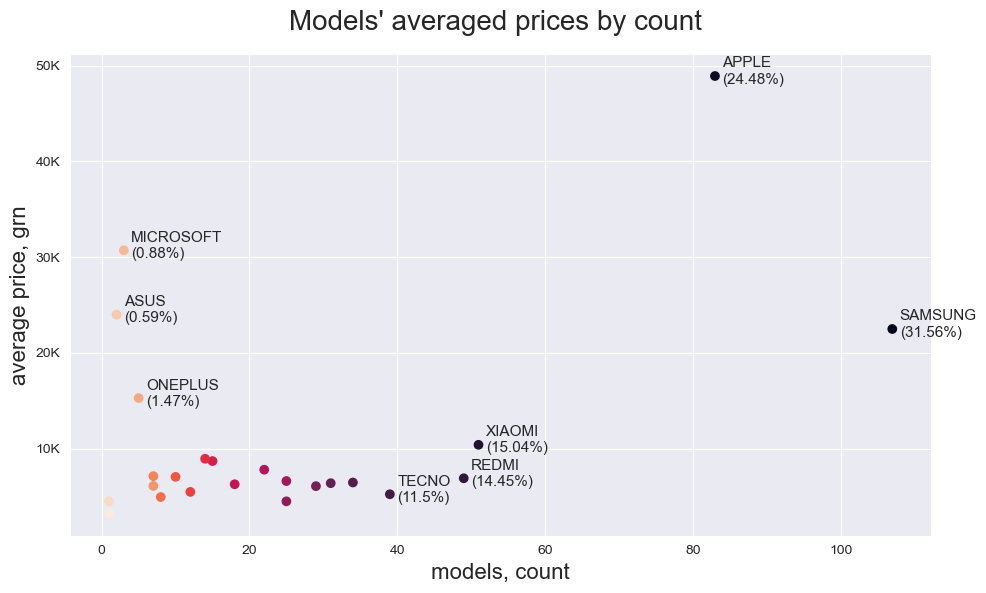

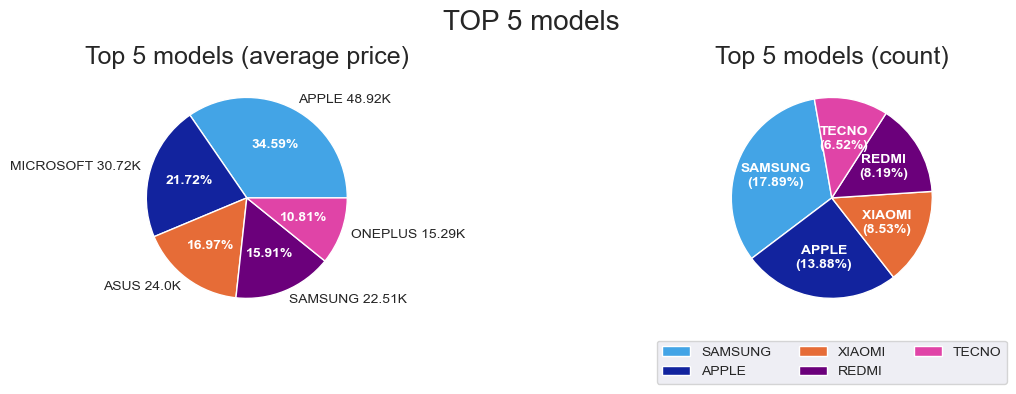

In [80]:
# function to get the string value percentage on the column
def get_percentage_str(data_frame_column, value, round_to):
    return str(round((value/sum(data_frame_column))*100,round_to))+"%"

sns.set_style('darkgrid') # dark grid style

df_vis = df[df['Ціна'] > 0] # not showing rows with 0 prices (out of stock)

avg_price_per_model = df_vis[['Модель','Ціна']].groupby('Модель', as_index=False)['Ціна'].mean() # average price per model
avg_price_per_model = avg_price_per_model.sort_values('Ціна', ascending=False) # sorting by price from biggest to lowest
count_per_model = df_vis['Модель'].value_counts() # models count per model
count_per_model = pd.DataFrame({'Модель': count_per_model.index, 'Середня кількість': count_per_model.values})
avg_price_count_per_model = pd.merge(avg_price_per_model, count_per_model, on=['Модель', 'Модель'])
avg_price_count_per_model = avg_price_count_per_model.sort_values('Середня кількість', ascending=False)


fig1 = plt.figure(figsize=(12,14)) # the first figure to plot on
ax1 = fig1.add_subplot(2,2,1) # add subplot to the fig1 (2 rows, 2 columns, 1st plotting)
ax1.invert_yaxis() # invert y axis
ax1.xaxis.set_major_formatter(lambda x,p: str(int(x/1000))+"K") # custom format x axis labels

plt.barh(avg_price_per_model['Модель'].values, avg_price_per_model['Ціна'].values) # horizontal bar chart model by price
plt.xlabel('average price, grn', fontsize=16) # x axis label
plt.title("Models average cost ratio", fontsize = 18) # chart title



ax2 = fig1.add_subplot(2,2,2) # add subplot to the fig1 (2 rows, 2 columns, 2nd plotting)
ax2.invert_yaxis() # invert y axis
plt.barh(count_per_model['Модель'].values, count_per_model['Середня кількість'].values) # horizontal bar chart model by count
plt.xlabel('models, count', fontsize=16) # x axis label
plt.title("Models count ratio", fontsize = 18) # chart title

fig1.tight_layout() # for the plots not to overlap



fig2 = plt.figure(figsize=(10,6)) # the second figure to plot on
fig2.suptitle("Models' averaged prices by count", fontsize = 20) # figure 2 title
ax3 = fig2.add_subplot(1,1,1) # add subplot to the fig2 (1 row, 1 column, 1st plotting)
ax3.yaxis.set_major_formatter(lambda x,p: str(int(x/1000))+"K") # custom format y axis labels
# scatter plot count by price
plt.scatter(avg_price_count_per_model['Середня кількість'].values, # x-values: average count per model
            avg_price_count_per_model['Ціна'].values, # y-values: average price per model
            c=[i for i in range(1, len(count_per_model.values)+1)]) # separate color for each model
plt.xlabel('models, count', fontsize=16) # x axis label
plt.ylabel('average price, grn', fontsize=16) # y axis label

# filter models to get the most popular and/or expensive models
models_filtered = avg_price_count_per_model[((avg_price_count_per_model['Ціна']>14000.0) & # prices bigger than 14K AND
                                             (avg_price_count_per_model['Середня кількість']<20.0)) # count less that 20 OR
                                            | (avg_price_count_per_model['Середня кількість']>37)] # count bigger than 37

for i, txt in enumerate(list(models_filtered['Модель'].values)): # for every filtered model
    # render labels in the custom formatting: model_name+count_percentage
    ax3.annotate(txt + "\n(" + get_percentage_str(models_filtered['Середня кількість'], models_filtered['Середня кількість'].values[i], 2) +")", 
                 (models_filtered['Середня кількість'].values[i]+1, # label x-val (+1 for better visual)
                  models_filtered['Ціна'].values[i]-800),  # label y-val (-800 for better visual)
                 size=11) # font-size

fig2.tight_layout() # for the plots not to overlap



fig3 = plt.figure(figsize=(12,10)) # the third figure to plot on
fig3.suptitle('TOP 5 models', fontsize=20) # figure 3 title
ax4 = fig3.add_subplot(3,2,1) # add subplot to the fig3 (3 rows, 2 columns, 1st plotting)
_, __, texts = plt.pie(avg_price_per_model['Ціна'].head().values, # the first 5 most expensive average price values per model
                       colors=['#43A4E6', '#12239E', '#E66C37', '#6B007B', '#E044A7'], # the colors for each model
                       autopct='%1.2f%%', # auto-estimation of percent in the float formatting
                       #custom value format for labels: model_name+(price/1000)K
                       labels=[k + " " + str(round(int(v)/1000,2))+"K" for k,v in avg_price_per_model.head().values],
                       textprops={'fontsize':10}) # size of the labels
    
for text in texts: # for each of labels of the plt.pie
    text.set_horizontalalignment('center') # align labels center
    text.set_color('white') # font color
    text.set_weight('bold') # font weight
    
plt.title("Top 5 models (average price)", fontsize = 18) # the pie plot title



ax5 = fig3.add_subplot(3,2,2)  # add subplot to the fig3 (3 rows, 2 columns, 2nd plotting)
_, texts = plt.pie(count_per_model['Середня кількість'].head().values, # the first 5 biggest average count values per model
                   colors=['#43A4E6', '#12239E', '#E66C37', '#6B007B', '#E044A7'],  # the colors for each model
                   startangle=100, # starting angle for the plot to be shown
                   labeldistance=0.6, # distance between labels and the pie center
                   # custom value format for labels: model_name+<br>+(percent_from_the_whole)%
                   labels=[str(k)+"\n("+ get_percentage_str(count_per_model['Середня кількість'], v, 2) +")" 
                           for k,v in count_per_model.head().values], 
                   textprops={'fontsize':10}) # size of the labels

for text in texts: # for each of labels of the plt.pie
    text.set_horizontalalignment('center')  # align labels center
    text.set_color('white') # font color
    text.set_weight('bold') # font weight

plt.title("Top 5 models (count)", fontsize = 18) # the pie plot title
# the pie plot legend
plt.legend(labels=count_per_model['Модель'].head().values, # labels are the five top models
           loc='upper center', # legend location
           bbox_to_anchor=(0.5, -0.04), # the corner's location
           ncol=3) # number of columns

fig3.tight_layout() # for the plots not to overlap



plt.show() # show the plots

## <center> Part 3: Analyzing and model learning </center>
### Стоїть задача вибору телефону. Фінансів вистачає на найдорожчу модель у магазині, але доцільність і релевантність витрати стоїть на першому місці. 
### Тож, постає необхідність вирішення задачі максимізації користі телефону за його ціну. Необхідними підзадачами до виконання є:
<ul><font size="4">
<li>врахування репутації та популярності на ринку кожної моделі (якщо їх занадто багато, взяти n найкращих);</li>
<li>зрозуміти принципи, за якими можна поділити всі телефони та розглядати їх, як окремі групи (що більше за все впливає на ціну телефону);</li>
<li>за допомогою найдоцільнішого методу навчити мережу розпізнавати модель телефону за відповідними характеристиками (включаючи ціну); перевірити здатність системи на реальних та майже- або не- реальних прикладах.</li>
</font></ul>

In [97]:
import random                                                                         # working with pseudo-random values
from sklearn.cluster import KMeans                                                    # kmeans exclusive clustering alg-thm
from sklearn.linear_model import LogisticRegression                                   # logistic regression alg-thm
from sklearn import tree                                                              # decision tree alg-thm
from sklearn.ensemble import RandomForestClassifier                                   # random forest alg-thm
from xgboost import XGBClassifier                                                     # XGB alg-thm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score   # analyzing learning results
from sklearn.model_selection import train_test_split                                  # splitting data for train/test
from sklearn.ensemble import VotingClassifier                                         # ensemble to use multiple alg-thms

In [98]:
display(df.head())
display(df.describe())

,Артикул,Назва,Фото,Ціна,Модель,Дисплей,Розмір дисплею,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка
0,345194,Смартфон NOKIA G10 3/32GB Night,https://i.can.ua/images/244x190/goods/8341/834...,3999,NOKIA,6.50,1600x720 (HD+),8,3,32,13.0,Android
1,346475,Смартфон REDMI Note 10 Pro 6/128GB Onyx Gray,https://i.can.ua/images/244x190/goods/8393/839...,9999,REDMI,6.67,2400x1080 (Full HD+),8,6,128,108.0,Android
2,349393,Смартфон ONEPLUS Nord N100 4/64GB Midnight Frost,https://i.can.ua/images/244x190/goods/8571/857...,6999,ONEPLUS,6.52,1600x720 (HD+),8,4,64,13.0,Android
3,364817,Смартфон VIVO Y31 4/64GB Ocean Blue,https://i.can.ua/images/244x190/goods/9284/928...,7173,VIVO,6.58,2400x1080 (Full HD+),8,4,64,48.0,Android
4,365575,Смартфон SAMSUNG Galaxy M52 6/128GB Light Blue...,https://i.can.ua/images/244x190/goods/9327/932...,11790,SAMSUNG,6.70,2400x1080 (Full HD+),8,6,128,64.0,Android


,Артикул,Ціна,Дисплей,Кількість ядер,Внутрішня пам'ять,Камера
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,378000.014257,9626.064155,6.398656,7.303462,119.845214,39.376171
std,29910.138488,15827.538988,0.431751,1.346861,102.782831,32.749700
min,95294.000000,0.000000,4.700000,4.000000,1.000000,4.000000
25%,374083.250000,0.000000,6.367500,8.000000,64.000000,13.000000
50%,387305.500000,4684.500000,6.500000,8.000000,128.000000,48.000000
75%,394836.750000,8495.500000,6.600000,8.000000,128.000000,50.000000
max,406100.000000,79052.000000,8.300000,8.000000,512.000000,200.000000


In [99]:
df = df.drop(['Артикул', 'Назва', 'Фото'], axis=1) # getting rid of useless columns
 # splitting display size by "(" to standrdize it, removing whitespaces
df['Розмір дисплею'] = df['Розмір дисплею'].apply(lambda x: x.split('(')[0].strip())

display(df['Розмір дисплею'].unique()) # unique display sizes
df.head()

array(['1600x720', '2400x1080', '1650x720', '2712x1220', '2796x1290',
       '3088x1440', '2340x1080', '2408x1080', '2460x1080', '1640x720',
       '1280x600', '1440x720', '1280x720', '960x480', '1560x720',
       '2208x1768', '1920x1080', '1792x828', '2532x1170', '1520x720',
       '2700x1800', '3216x1440', '2688x1892', '1612x720', '2640x1080',
       '2412x1080', '2176x1812', '1014x480', '2560x1179', '2778x1284',
       '3200x1440', '960x540', '2160x1080', '2280x1080', '960x442',
       '2388x1080', '1480x720', '1334x750'], dtype=object)

,Ціна,Модель,Дисплей,Розмір дисплею,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка
0,3999,NOKIA,6.50,1600x720,8,3,32,13.0,Android
1,9999,REDMI,6.67,2400x1080,8,6,128,108.0,Android
2,6999,ONEPLUS,6.52,1600x720,8,4,64,13.0,Android
3,7173,VIVO,6.58,2400x1080,8,4,64,48.0,Android
4,11790,SAMSUNG,6.70,2400x1080,8,6,128,64.0,Android


In [100]:
df = pd.get_dummies(df, columns=['Розмір дисплею']) # divide 'Розмір дисплею' column into separate columns

display(df.head())
display(df['Операційка'].unique()) # unique values of OSes

,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
0,3999,NOKIA,6.50,8,3,32,13.0,Android,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9999,REDMI,6.67,8,6,128,108.0,Android,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6999,ONEPLUS,6.52,8,4,64,13.0,Android,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7173,VIVO,6.58,8,4,64,48.0,Android,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11790,SAMSUNG,6.70,8,6,128,64.0,Android,0,0,...,0,0,0,0,0,0,0,0,0,0


array(['Android', 'iOS',
       'Android (без поддержки Google Services та Play Market)'],
      dtype=object)

In [101]:
df['Операційка'] = df['Операційка'].apply(lambda x: 0 if x == 'Android (без поддержки Google Services та Play Market)' or x == 'Android' else (1 if x == 'iOS' else 'unfamiliar model'))

display(df['Операційка'].unique())
display(df.head())
display(df.describe())

array([0, 1], dtype=int64)

,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
0,3999,NOKIA,6.50,8,3,32,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9999,REDMI,6.67,8,6,128,108.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6999,ONEPLUS,6.52,8,4,64,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7173,VIVO,6.58,8,4,64,48.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11790,SAMSUNG,6.70,8,6,128,64.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Ціна,Дисплей,Кількість ядер,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,Розмір дисплею_1280x720,Розмір дисплею_1334x750,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,...,982.000000,982.000000,982.00000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,9626.064155,6.398656,7.303462,119.845214,39.376171,0.116090,0.001018,0.004073,0.017312,0.002037,...,0.002037,0.006110,0.01833,0.016293,0.014257,0.002037,0.001018,0.004073,0.014257,0.001018
std,15827.538988,0.431751,1.346861,102.782831,32.749700,0.320496,0.031911,0.063725,0.130496,0.045106,...,0.045106,0.077967,0.13421,0.126665,0.118607,0.045106,0.031911,0.063725,0.118607,0.031911
min,0.000000,4.700000,4.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.367500,8.000000,64.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4684.500000,6.500000,8.000000,128.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8495.500000,6.600000,8.000000,128.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,79052.000000,8.300000,8.000000,512.000000,200.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
df_learn = df.copy() # dataframe for alg-thms to be learnt

display(df_learn.shape) # sizes (rows, columns)

df_learn = df_learn.drop(df_learn[df_learn['Ціна']==0].index) # drop 0 prices (out of stock; no info)

display(df_learn.shape) # sizes (rows, columns)
display(df_learn.head())

(982, 46)

(598, 46)

,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
0,3999,NOKIA,6.50,8,3,32,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9999,REDMI,6.67,8,6,128,108.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6999,ONEPLUS,6.52,8,4,64,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7173,VIVO,6.58,8,4,64,48.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11790,SAMSUNG,6.70,8,6,128,64.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
model_counts = df_learn['Модель'].value_counts() # counts per model

model_counts

SAMSUNG         107
APPLE            83
XIAOMI           51
REDMI            49
TECNO            39
ULEFONE          34
REALME           31
UMIDIGI          29
BLACKVIEW        25
ZTE              25
INFINIX          22
MOTOROLA         18
OPPO             15
VIVO             14
NOKIA            12
TCL              10
OSCAL             8
SIGMA MOBILE      7
DOOGEE            7
ONEPLUS           5
MICROSOFT         3
ASUS              2
ALCATEL           1
MAXCOM            1
Name: Модель, dtype: int64

In [104]:
df_learn = df_learn[df_learn['Модель'].isin(model_counts.head().index)] # leave only the top 5 most popular models
unique_models = df_learn['Модель'].unique() # check all the unique models in df for learning

unique_models

array(['REDMI', 'SAMSUNG', 'XIAOMI', 'APPLE', 'TECNO'], dtype=object)

In [105]:
price_0_models = df[df['Ціна']==0] # save 0 prices to the separate df
# leave there the same models as in df for learning
price_0_models = price_0_models[price_0_models['Модель'].isin(unique_models)]

price_0_models.head()

,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
599,0,APPLE,6.70,6,6,1,48.0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
607,0,XIAOMI,6.36,8,8,256,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,0,XIAOMI,6.36,8,8,256,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
609,0,XIAOMI,6.55,8,8,256,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,0,XIAOMI,6.73,8,12,256,50.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [106]:
# std of price per model
std_price_per_model = df_learn[['Модель','Ціна']].groupby('Модель', as_index=False)['Ціна'].std()
# in avg price leave the same models as in learning df
avg_price_per_model = avg_price_per_model[avg_price_per_model['Модель'].isin(unique_models)]

display(avg_price_per_model)
display(std_price_per_model)

,Модель,Ціна
1,APPLE,48919.265060
15,SAMSUNG,22506.962617
22,XIAOMI,10413.450980
14,REDMI,6920.571429
18,TECNO,5250.974359


,Модель,Ціна
0,APPLE,13902.628540
1,REDMI,2520.550370
2,SAMSUNG,18996.748510
3,TECNO,2124.390420
4,XIAOMI,4306.303302


In [107]:
for model in unique_models: # for every top model
    curr_model_std = std_price_per_model[std_price_per_model['Модель']==model]['Ціна'].values[0] # curr model's price std
    curr_model_avg = avg_price_per_model[avg_price_per_model['Модель'] == model]['Ціна'].values[0] # curr model's price avg
    # for every price in 0 price df change price into average price for the model +- its std price
    price_0_models.loc[price_0_models['Модель']==model, 'Ціна'] = price_0_models[price_0_models['Модель']==model]['Ціна']\
    .apply(lambda x: curr_model_avg + random.uniform(-curr_model_std, curr_model_std))
    
display(price_0_models.head())
display(df_learn.head())

,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
599,56325.370466,APPLE,6.70,6,6,1,48.0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
607,7965.037372,XIAOMI,6.36,8,8,256,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,11220.094291,XIAOMI,6.36,8,8,256,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
609,10683.970295,XIAOMI,6.55,8,8,256,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,12127.805662,XIAOMI,6.73,8,12,256,50.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
1,9999,REDMI,6.67,8,6,128,108.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11790,SAMSUNG,6.70,8,6,128,64.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6999,REDMI,6.71,8,4,128,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4208,XIAOMI,6.71,8,3,32,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,22565,XIAOMI,6.67,8,8,256,108.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [108]:
df_learn['Модель'] = df_learn['Модель'].apply(lambda x: list(unique_models).index(x)) # encode models as indexes
df_to_predict_res = price_0_models['Модель'].apply(lambda x: list(unique_models).index(x)) # encode models for 0 models also
df_to_predict = price_0_models.drop('Модель',axis=1) # delete value for prediction from the test df

display(df_learn.head())
display(df_to_predict.head())
display(df_to_predict_res.head())

,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
1,9999,0,6.67,8,6,128,108.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11790,1,6.70,8,6,128,64.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6999,0,6.71,8,4,128,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4208,2,6.71,8,3,32,13.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,22565,2,6.67,8,8,256,108.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


,Ціна,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,Розмір дисплею_1280x600,Розмір дисплею_1280x720,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
599,56325.370466,6.70,6,6,1,48.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
607,7965.037372,6.36,8,8,256,50.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,11220.094291,6.36,8,8,256,50.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
609,10683.970295,6.55,8,8,256,50.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,12127.805662,6.73,8,12,256,50.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


599    3
607    2
608    2
609    2
610    2
Name: Модель, dtype: int64

In [109]:
try:
    # trying to parse all columns in all dfs as floats to check for any remaining string-ish elements
    df_learn = df_learn.astype('float')
    df_to_predict = df_to_predict.astype('float')
    df_to_predict_res = df_to_predict_res.astype('float')
except Exception as e: # in case of error
    print(e) # print the error
finally: # anyway
    print("Done")

Done


D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


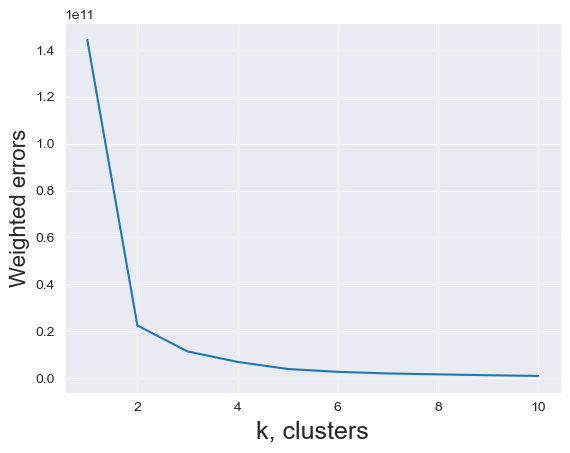

In [110]:
distortions = [] # list for appending inertias for the elbow method
for k in range(1,11): # estimate kmeans for different number of clusters (from 1 to 10)
    kmean = KMeans(n_clusters=k, # amount of clusters
               n_init=15 # number of times to repeat algorithm to find better centroids
              ).fit(df_learn)

    distortions.append(kmean.inertia_) # Sum of squared distances of samples to their closest cluster center
    
# plotting
plt.plot([i for i in range(1,11)], # x values
         distortions) # y values
plt.xlabel('k, clusters', fontsize=18) # x axis label
plt.ylabel('Weighted errors', fontsize=16) # y axis label

plt.show()

In [111]:
# we're choosing between
kmeans_2_cl = KMeans(n_clusters=2, n_init=15).fit(df_learn) # 2 clusters kmeans
kmeans_3_cl = KMeans(n_clusters=3, n_init=15).fit(df_learn) # 3 clusters kmeans

df_2_clusters, df_3_clusters = df_learn.copy(), df_learn.copy() # copy df for learning for each kmeans
df_2_clusters['Cluster'] = kmeans_2_cl.labels_ # create the 'Cluster' column to associate each row (model) with its cluster
df_3_clusters['Cluster'] = kmeans_3_cl.labels_

df_grouped_2 = df_2_clusters.groupby('Cluster', as_index=False).mean() # group by cluster and get means (for analysis)
df_grouped_3 = df_3_clusters.groupby('Cluster', as_index=False).mean()

display(df_grouped_2)
display(df_grouped_2.describe())
display(df_grouped_3)
display(df_grouped_3.describe())

,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
0,0,9100.774194,1.585253,6.552212,7.686636,4.686636,104.184332,48.953917,0.018433,0.0,...,0.0,0.009217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,49720.160714,2.410714,6.356250,6.589286,6.714286,272.062500,42.089286,0.705357,0.0,...,0.0,0.000000,0.116071,0.133929,0.098214,0.0,0.0,0.0,0.0,0.0


,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,...,2.0,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0
mean,0.500000,29410.467454,1.997984,6.454231,7.137961,5.700461,188.123416,45.521601,0.361895,0.0,...,0.0,0.004608,0.058036,0.066964,0.049107,0.0,0.0,0.0,0.0,0.0
std,0.707107,28722.243656,0.583689,0.138566,0.775944,1.433765,118.707791,4.854027,0.485729,0.0,...,0.0,0.006517,0.082075,0.094702,0.069448,0.0,0.0,0.0,0.0,0.0
min,0.000000,9100.774194,1.585253,6.356250,6.589286,4.686636,104.184332,42.089286,0.018433,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.250000,19255.620824,1.791619,6.405240,6.863623,5.193548,146.153874,43.805444,0.190164,0.0,...,0.0,0.002304,0.029018,0.033482,0.024554,0.0,0.0,0.0,0.0,0.0
50%,0.500000,29410.467454,1.997984,6.454231,7.137961,5.700461,188.123416,45.521601,0.361895,0.0,...,0.0,0.004608,0.058036,0.066964,0.049107,0.0,0.0,0.0,0.0,0.0
75%,0.750000,39565.314084,2.204349,6.503221,7.412298,6.207373,230.092958,47.237759,0.533626,0.0,...,0.0,0.006912,0.087054,0.100446,0.073661,0.0,0.0,0.0,0.0,0.0
max,1.000000,49720.160714,2.410714,6.552212,7.686636,6.714286,272.062500,48.953917,0.705357,0.0,...,0.0,0.009217,0.116071,0.133929,0.098214,0.0,0.0,0.0,0.0,0.0


,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
0,0,40745.812500,2.375000,6.184375,6.625000,6.031250,228.000000,25.562500,0.687500,0.0,...,0.0,0.000000,0.156250,0.000000,0.031250,0.0,0.0,0.0,0.0,0.0
1,1,9022.541667,1.587963,6.552917,7.685185,4.671296,103.481481,49.125000,0.018519,0.0,...,0.0,0.009259,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,2,60957.653061,2.428571,6.581633,6.571429,7.632653,329.285714,63.061224,0.714286,0.0,...,0.0,0.000000,0.061224,0.306122,0.183673,0.0,0.0,0.0,0.0,0.0


,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
count,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,...,3.0,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.0,3.0,3.0
mean,1.0,36908.669076,2.130511,6.439641,6.960538,6.111733,220.255732,45.916241,0.473435,0.0,...,0.0,0.003086,0.072491,0.102041,0.071641,0.0,0.0,0.0,0.0,0.0
std,1.0,26179.318195,0.470624,0.221533,0.628134,1.482318,113.101141,18.954173,0.394197,0.0,...,0.0,0.005346,0.078732,0.176740,0.098273,0.0,0.0,0.0,0.0,0.0
min,0.0,9022.541667,1.587963,6.184375,6.571429,4.671296,103.481481,25.562500,0.018519,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.5,24884.177083,1.981481,6.368646,6.598214,5.351273,165.740741,37.343750,0.353009,0.0,...,0.0,0.000000,0.030612,0.000000,0.015625,0.0,0.0,0.0,0.0,0.0
50%,1.0,40745.812500,2.375000,6.552917,6.625000,6.031250,228.000000,49.125000,0.687500,0.0,...,0.0,0.000000,0.061224,0.000000,0.031250,0.0,0.0,0.0,0.0,0.0
75%,1.5,50851.732781,2.401786,6.567275,7.155093,6.831952,278.642857,56.093112,0.700893,0.0,...,0.0,0.004630,0.108737,0.153061,0.107462,0.0,0.0,0.0,0.0,0.0
max,2.0,60957.653061,2.428571,6.581633,7.685185,7.632653,329.285714,63.061224,0.714286,0.0,...,0.0,0.009259,0.156250,0.306122,0.183673,0.0,0.0,0.0,0.0,0.0


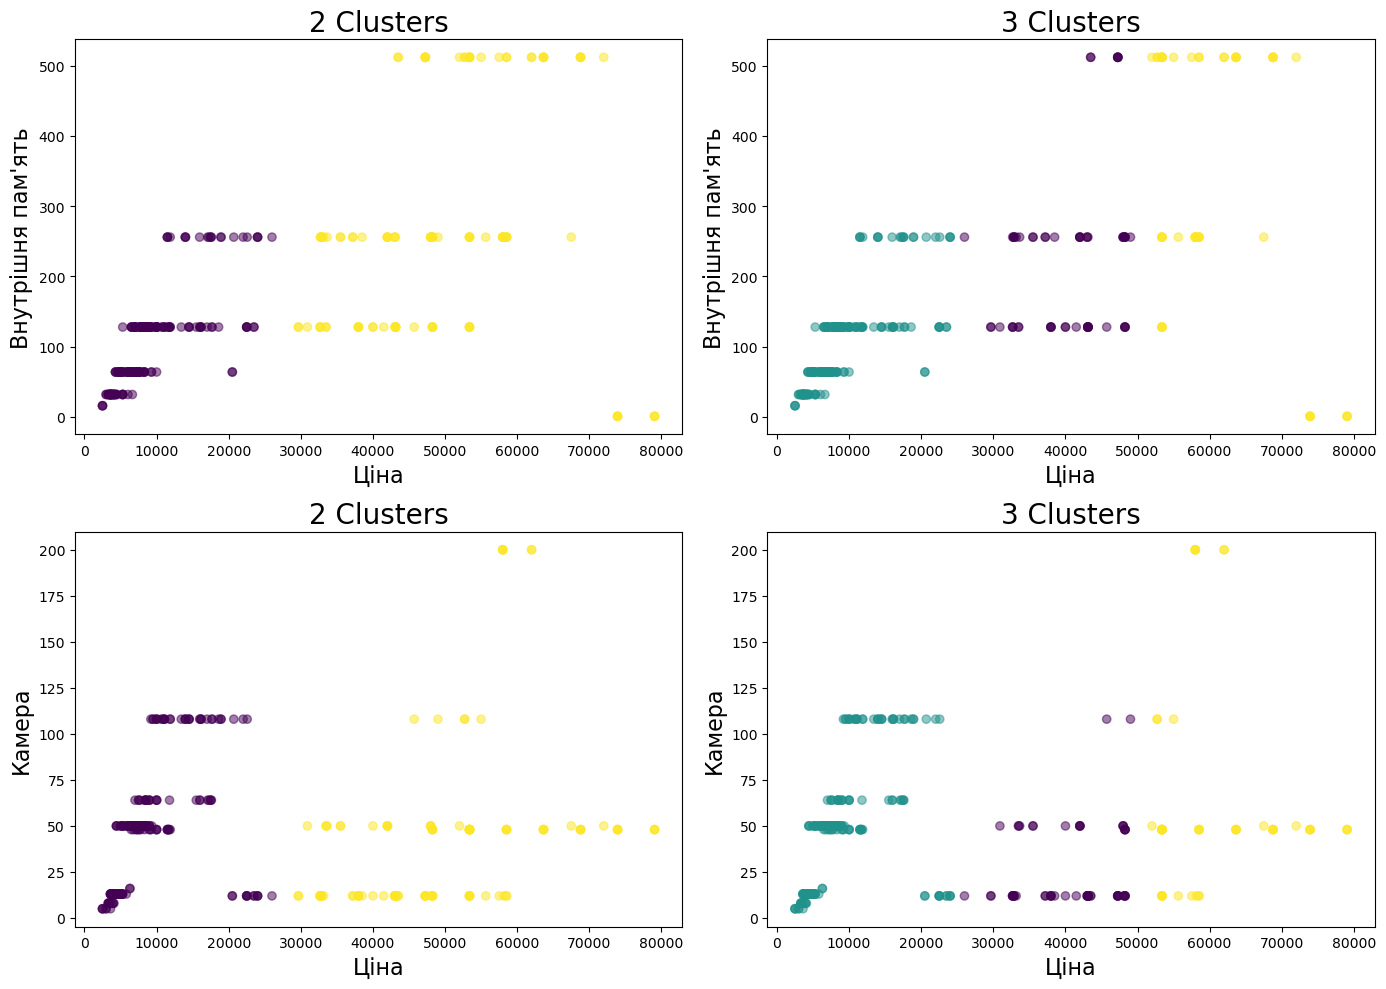

In [112]:
# plotting clusters with c different colors for each separate cluster
sns.reset_orig() # get back to standard bg


fig = plt.figure(figsize=(14,10)) # the first figure to plot on
plt.subplot(2, 2, 1) # add subplot (2 rows, 2 columns, 1st plotting)
# scatter plot price by device memory colored separately for each cluster, half transparent (2 clusters)
plt.scatter(df_2_clusters['Ціна'], df_2_clusters["Внутрішня пам'ять"], c=df_2_clusters['Cluster'], alpha=.5)
plt.title("2 Clusters", fontsize=20) # the scatter plot title
plt.xlabel('Ціна', fontsize=16) # x axis label
plt.ylabel("Внутрішня пам'ять", fontsize=16) # y axis label



plt.subplot(2, 2, 2) # add subplot (2 rows, 2 columns, 2nd plotting)
# scatter plot price by device memory colored separately for each cluster, half transparent (3 clusters)
plt.scatter(df_3_clusters['Ціна'], df_3_clusters["Внутрішня пам'ять"], c=df_3_clusters['Cluster'], alpha=.5)
plt.title("3 Clusters", fontsize=20) # the scatter plot title
plt.xlabel('Ціна', fontsize=16) # x axis label
plt.ylabel("Внутрішня пам'ять", fontsize=16) # y axis label



plt.subplot(2, 2, 3) # add subplot (2 rows, 2 columns, 3rd plotting)
# scatter plot price by camera colored separately for each cluster, half transparent (2 clusters)
plt.scatter(df_2_clusters['Ціна'], df_2_clusters["Камера"], c=df_2_clusters['Cluster'], alpha=.5)
plt.title("2 Clusters", fontsize=20) # the scatter plot title
plt.xlabel('Ціна', fontsize=16) # x axis label
plt.ylabel("Камера", fontsize=16) # y axis label



plt.subplot(2, 2, 4) # add subplot (2 rows, 2 columns, 4th plotting)
# scatter plot price by camera colored separately for each cluster, half transparent (3 clusters)
plt.scatter(df_3_clusters['Ціна'], df_3_clusters["Камера"], c=df_3_clusters['Cluster'], alpha=.5)
plt.title("3 Clusters", fontsize=20) # the scatter plot title
plt.xlabel('Ціна', fontsize=16) # x axis label
plt.ylabel("Камера", fontsize=16) # y axis label

fig.tight_layout() # for the plots not to overlap


plt.show() # show the plots

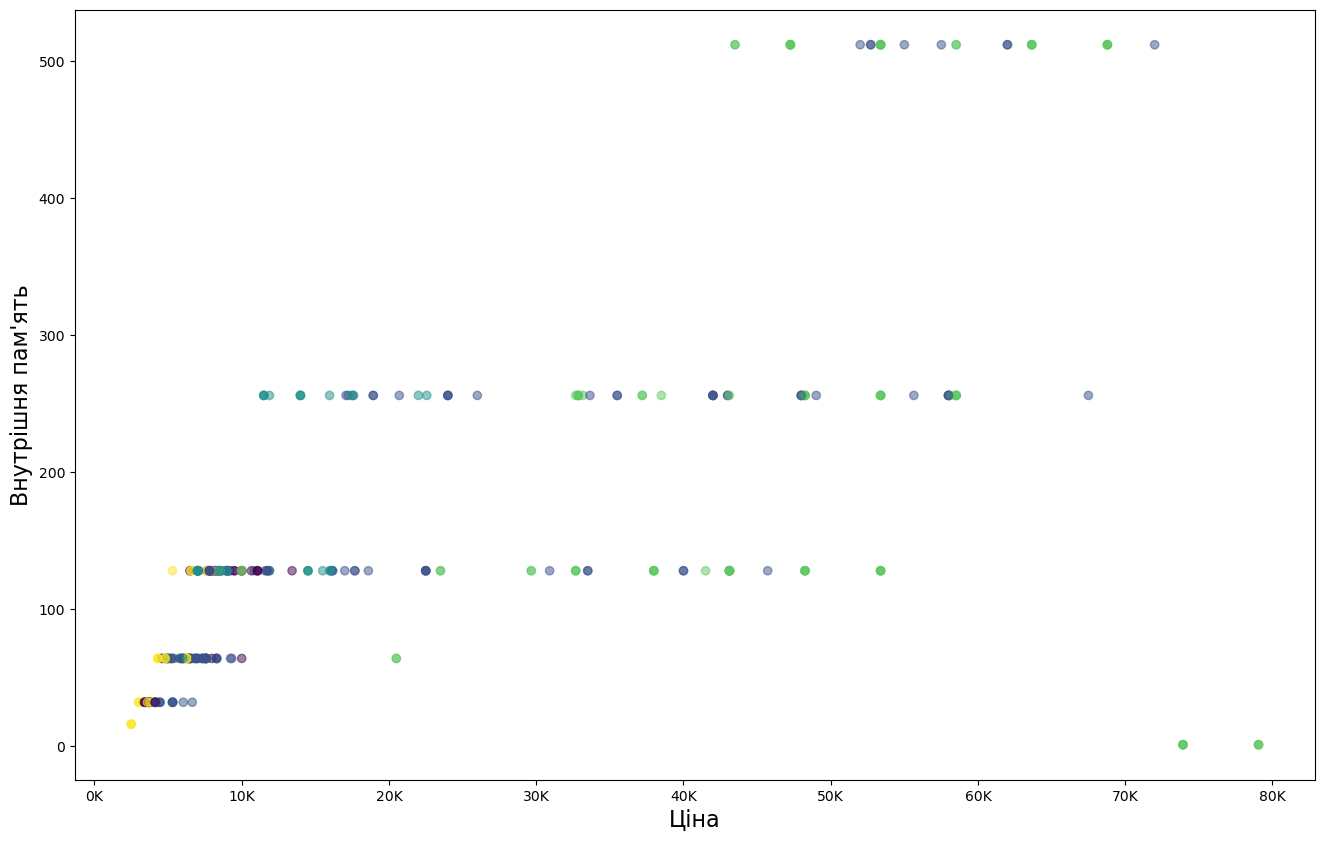

In [121]:
fig = plt.figure(figsize=(16,10)) # the first figure to plot on
ax = plt.subplot(1,1,1) # add subplot (1 row, 1 column, 1st plotting)
# scatter plot price by device memory colored separately for each cluster, half transparent (3 clusters)
ax.scatter(df_3_clusters['Ціна'], df_3_clusters["Внутрішня пам'ять"], c=df_3_clusters['Модель'], alpha=.5)
ax.xaxis.set_major_formatter(lambda x,p: str(int(x/1000))+"K") # custom format y axis labels
plt.xlabel('Ціна', fontsize=16) # x axis label
plt.ylabel("Внутрішня пам'ять", fontsize=16) # y axis label

plt.show() # show the plot

In [122]:
# dividing df for learning into separate dfs
X = df_learn.drop('Модель', axis=1).astype('float') # independent (x) values

Y = df_learn['Модель'] # dependent value (y) for predicting

X_train, X_test, y_train, y_test = train_test_split(X, # independent variables
                                                    Y, # dependent variable (expected output)
                                                    random_state=1, # pseudo-random number parameter to reproduce the same train test split each time you run the code 
                                                    train_size = .75) # 75% is aimed for training, other 25% - for testing


In [124]:
# дерево рішень
# easy model with least data preparation. Based on multiple statistical choice,
# but even slight difference in data can significantly impact the final solution
# - calculate gini impurity for all impure leafes (that are of ambigious choice)
# for every independent variable: 1 - probability of true/n - probability of false/n
# (for non-binary values we calculate average of every pair and check if the current value
# less or bigger than the current average)
# - for the root element of the tree the least gini impurity is chosen
# - for further leafs reduce impurity by adding other calculated leafs
# - recalculate gini impurity for elements that were filtered by the root elements
decision_tree = tree.DecisionTreeClassifier().fit(X_train, y_train) # fit the splitted data from df_learn
dtree_predictions = decision_tree.predict(X_test) # test how good is this algorythm

print("Accuracy of Dicision Tree: {0}%".format(accuracy_score(y_test, dtree_predictions) * 100))
print(confusion_matrix(y_test, dtree_predictions)) 
print(classification_report(y_test, dtree_predictions))

Accuracy of Dicision Tree: 95.18072289156626%
[[11  0  1  0  0]
 [ 0 26  2  0  0]
 [ 0  1 14  0  0]
 [ 0  0  0 22  0]
 [ 0  0  0  0  6]]
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.96      0.93      0.95        28
         2.0       0.82      0.93      0.87        15
         3.0       1.00      1.00      1.00        22
         4.0       1.00      1.00      1.00         6

    accuracy                           0.95        83
   macro avg       0.96      0.96      0.96        83
weighted avg       0.96      0.95      0.95        83



In [125]:
# логістична регресія
# logistic regression has a sygmoid to fit the data rather than a stright line
# it also predicts binary values, not discrete ones, lika the linear regression
# instead of minimizing sum of residual squares (we can also get rid off non-helping
# independent variables):
# 1. pick a probability, scaled by weight
# 2. using it calculate the likelihood of the prediction being "False"
# 3. do this for all data and multiply them - that is the likelihood of the data
# according to the current sigmoid
# 4. shift the line and repeat 1-4 until we reach the maximum likelihood
fit_lg = LogisticRegression(penalty='none').fit(X_train, y_train) # fit the splitted data from df_learn
lg_predictions = fit_lg.predict(X_test) # test how good is this algorythm

print("Accuracy of Logistic Regression: {0}%".format(accuracy_score(y_test, lg_predictions) * 100))
print(confusion_matrix(y_test, lg_predictions))
print(classification_report(y_test, lg_predictions))

Accuracy of Logistic Regression: 55.42168674698795%
[[ 4  2  5  0  1]
 [ 3 15  5  5  0]
 [ 4  5  4  0  2]
 [ 0  0  0 22  0]
 [ 1  2  2  0  1]]
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33        12
         1.0       0.62      0.54      0.58        28
         2.0       0.25      0.27      0.26        15
         3.0       0.81      1.00      0.90        22
         4.0       0.25      0.17      0.20         6

    accuracy                           0.55        83
   macro avg       0.45      0.46      0.45        83
weighted avg       0.54      0.55      0.54        83



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [146]:
# random forest
# similar to the Tree Clasifier, but it may build hundreds of trees randomly
# and then, predictin the data, we run our test data through every tree and
# then venture the decision according to the most votes
rf = RandomForestClassifier(n_estimators = 800, random_state = 41).fit(X_train, y_train) # fit the splitted data from df_learn
rf_predictions = rf.predict(X_test) # test how good is this algorythm
accuracy_score_rf = accuracy_score(y_test, rf_predictions)

print("Accuracy of Logistic Regression: {0}%".format(accuracy_score_rf * 100))
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Accuracy of Logistic Regression: 97.59036144578313%
[[11  0  1  0  0]
 [ 0 28  0  0  0]
 [ 0  1 14  0  0]
 [ 0  0  0 22  0]
 [ 0  0  0  0  6]]
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.97      1.00      0.98        28
         2.0       0.93      0.93      0.93        15
         3.0       1.00      1.00      1.00        22
         4.0       1.00      1.00      1.00         6

    accuracy                           0.98        83
   macro avg       0.98      0.97      0.97        83
weighted avg       0.98      0.98      0.98        83



In [130]:
# trying out ensemble
estimators = [('decision_tree', decision_tree), ("RForest", rf)] # set of algorythms to combine
ensemble = VotingClassifier(estimators, # the algorythms
                            voting='hard') # make predicitions by majority vote

ensemble.fit(X_train, y_train) # fit the splitted data from df_learn
Y_prediction = ensemble.predict(X_test) # test how good is this algorythm

print(classification_report(Y_prediction,y_test))
print("Voting Ensemble:>" + str(accuracy_score(Y_prediction,y_test)*100) + "%")

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       1.00      0.97      0.98        29
         2.0       0.93      0.93      0.93        15
         3.0       1.00      1.00      1.00        22
         4.0       1.00      1.00      1.00         6

    accuracy                           0.98        83
   macro avg       0.97      0.98      0.97        83
weighted avg       0.98      0.98      0.98        83

Voting Ensemble:>97.59036144578313%


In [131]:
predictions = rf.predict(df_to_predict) # predicting 0 prices models with pseudo-randomized prices using the best alg

print(classification_report(predictions,df_to_predict_res))
print("Result:>" + str(accuracy_score(predictions,df_to_predict_res)*100) + "%")

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76        29
         1.0       0.86      0.84      0.85        77
         2.0       0.47      0.65      0.55        26
         3.0       1.00      1.00      1.00        31
         4.0       0.89      0.59      0.71        27

    accuracy                           0.79       190
   macro avg       0.79      0.77      0.77       190
weighted avg       0.82      0.79      0.80       190

Result:>79.47368421052632%


In [141]:
avg_price_per_model

,Модель,Ціна
1,APPLE,48919.265060
15,SAMSUNG,22506.962617
22,XIAOMI,10413.450980
14,REDMI,6920.571429
18,TECNO,5250.974359


In [134]:
# minimizing prices, maximizing attributes (for each OS)
predictions = rf.predict([[5250.974359, 7.6, 8, 12, 512, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                         [5250.974359, 7.6, 8, 12, 512, 200, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
                         ]) 

display(predictions)
display(unique_models)

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1., 3.])

array(['REDMI', 'SAMSUNG', 'XIAOMI', 'APPLE', 'TECNO'], dtype=object)

## <center>Summary</center>
### Врахувавши популярність кожної моделі, вибір було звужено до наступних п'яти:

In [145]:
avg_price_per_model['Модель']

1       APPLE
15    SAMSUNG
22     XIAOMI
14      REDMI
18      TECNO
Name: Модель, dtype: object

#### Ціна будь-якої моделі сильно залежить від камери, внутрішньої пам'яті та бренду. Всі моделі  було вирішено поділити на сегмент бюджетний:

In [114]:
df_grouped_3[df_grouped_3['Cluster']==2]

,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
2,2,8584.566038,1.561321,6.556557,7.641509,4.504717,96.377358,47.886792,0.009434,0.0,...,0.0,0.009434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


середній:

In [115]:
df_grouped_3[df_grouped_3['Cluster']==1]

,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
1,1,61905.92,2.48,6.566,6.52,7.48,317.6,62.0,0.74,0.0,...,0.0,0.0,0.08,0.32,0.18,0.0,0.0,0.0,0.0,0.0


дорогий:

In [116]:
df_grouped_3[df_grouped_3['Cluster']==0]

,Cluster,Ціна,Модель,Дисплей,Кількість ядер,Оперативна пам'ять,Внутрішня пам'ять,Камера,Операційка,Розмір дисплею_1014x480,...,Розмір дисплею_2700x1800,Розмір дисплею_2712x1220,Розмір дисплею_2778x1284,Розмір дисплею_2796x1290,Розмір дисплею_3088x1440,Розмір дисплею_3200x1440,Розмір дисплею_3216x1440,Розмір дисплею_960x442,Розмір дисплею_960x480,Розмір дисплею_960x540
0,0,40046.324324,2.378378,6.131081,6.621622,5.945946,236.972973,25.027027,0.689189,0.0,...,0.0,0.0,0.121622,0.0,0.040541,0.0,0.0,0.0,0.0,0.0


<font size="3">
    &emsp;Найдоцільнішим методом навчання мережі виявився <b>Random Forest</b>. Для данної моделі не підійшли б методи чисельного наближення або пошуку загальних закономірностей, адже бюджетний сегмент має дуже високу щільність значень, частина з яких не пов'язана по групах.<br>
&emsp;Точність навченої моделі склала <b>97.59036144578313%</b> для справжньої вибірки і <b>79.47368421052632%</b> для імітованої.<br>
&emsp;Тож, довіряючи системі можемо вирішити задачу мінімізації ціни при максимізації параметрів відповідно для кожної з ОС:
<ul>
    <li>Для Android найкращим вибором буде модель SAMSUNG;</li>
    <li>Для iOS найкращим вибором буде модель Apple;</li>
</ul>
&emsp;Оскільки, на основі досліджених даних для Apple переплата йде значною кількістю за бренд (найвище середнє значення ціни при досить великій кількості моделей), ця альтернатива виключається.<br>
&emsp;<b>Фінальний вибір залишається за моделлю SAMSUNG.</b>
</font>